### Hypotheses
* **H0 (Null Hypothesis):** There is no statistically significant difference in the conversion rate between users who see a non-discounted offer (Group A) and users who see a discounted offer (Group B).
* **H1 (Alternative Hypothesis):** Users who see the discounted offer (Group B) are more likely to purchase a weekly subscription compared to Group A.
---
### User Segmentation Criteria

The users included in the test sample must meet the following criteria:

* Users who have recently installed the app (within 7 days).
* Users who have not yet purchased a subscription.
* Users who see the subscription offer screen.

Conversely, we are excluding users from the test who:

* Have already purchased a subscription.
* Have seen the previous offer (as they are aware that $4.99 is the non-discounted price).

In [2]:
##We'll begin by importing the libraries we need
import scipy.stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

1. To start, we'll load the data from the file and show the A/B test results.

In [3]:
df_testing = pd.read_csv('/Users/elena/Desktop/Goit Data Analysis/Python/ab_test_data.csv')
df_testing.head(10)

,user_id,timestamp,test_group,conversion
0,7f6833e6-1141-4f20-b4b2-f1e31019b1fd,2023-07-04 04:40:55.848109,a,0
1,e6a6e960-d3f3-4074-a516-ba1e609b211e,2023-07-06 00:26:45.486187,b,0
2,4d3fbfa5-6847-410a-bac2-477f01d5f400,2023-07-10 20:24:33.639464,b,0
3,361457d9-a044-48f7-981c-d67dc3861679,2023-07-20 07:04:49.957013,b,0
4,285cd63d-7d03-427f-a062-1fa2dd2e77d6,2023-07-19 23:27:50.116680,b,0
5,0c6aad3a-8068-473c-98ea-88abbcacbe67,2023-07-15 21:13:55.067827,b,0
6,397c76e4-a4db-4712-b3ce-febfb13cb634,2023-07-18 07:03:05.315509,b,0
7,9b1f084d-8a7f-4526-b859-4935ca99482c,2023-07-17 12:11:21.902593,a,0
8,37ade847-cd45-4ca7-99c6-13fe881e7f42,2023-07-24 23:35:24.243933,b,0
9,b856113a-75d4-4911-894c-4d4c75f37c34,2023-07-22 19:38:24.460128,a,0


The number of users in groups A and B is as follows:

In [4]:
user_counts = df_testing['test_group'].value_counts()
users_a = user_counts.get('a', 0) ##user count in group A
users_b = user_counts.get('b', 0) ##user count in group B

print(f"Group A users count: {user_counts.get('a', 0)}") 
print(f"Group B users count: {user_counts.get('b', 0)}") 

Group A users count: 10013
Group B users count: 9985


So, we have 10,013 users in Group A and 9,985 users in Group B. While these groups are not of the exact same size, this is acceptable for A/B testing.

Next, we'll calculate the number of conversions for each group.

In [19]:
conversion_counts = df_testing[df_testing["conversion"] == 1].groupby("test_group").size()
conversions_a = conversion_counts.get('a', 0) ##conversion count in group A
conversions_b = conversion_counts.get('b', 0) ##conversion count in group B

print(f"Group A conversions count: {conversion_counts.get('a', 0)}")
print(f"Group B conversions count: {conversion_counts.get('b', 0)}")

Group A conversions count: 611
Group B conversions count: 889


Then, we calculate the conversion rate for groups A and B, respectively.

In [23]:
conversion_rate_a = (conversions_a / users_a) * 100 if users_a > 0 else 0
conversion_rate_b = (conversions_b / users_b) * 100 if users_b > 0 else 0

print (f"Group A conversion rate: {round(conversion_rate_a,2)}")
print (f"Group B conversion rate: {round(conversion_rate_b,2)}")

Group A conversion rate: 6.1
Group B conversion rate: 8.9


We'll now find the test's start and end dates and calculate its duration in days.

In [7]:
df_testing['timestamp'] = pd.to_datetime(df_testing['timestamp'])

In [21]:
df_testing['date'] = df_testing['timestamp'].dt.date
start_date = df_testing['date'].min() ##test start date
end_date = df_testing['date'].max() ##test end date
duration_days = (end_date - start_date).days + 1 ##We add +1 to include the start date into test duration

print(f"\nTest start date: {start_date}")
print(f"\nTest end date: {end_date}")
print(f"\nTest duration (days): {duration_days}")


Test start date: 2023-07-03

Test end date: 2023-07-25

Test duration (days): 23


So, this test lasted for 23 days. Depending on factors such as the statistical significance and power levels, the user behavior cycle, and other variables, this duration may be either sufficient or too long.

2. Next, based on the data, we will investigate whether the conversion difference between the two groups is due to random chance or if it's a genuine effect, proving that the change to the pricing message works. Since we are working with conversion data, we cannot assume a normal distribution.
Therefore, the permutation test was chosen to evaluate the test results. This non-parametric test allows us to obtain accurate results by accounting for the sample size and the absence of a normal distribution.

In [22]:
group_a = np.array([1]*611 + [0]*(10013 - 611)) # Group A: 6,1% conversion with 10013 users
group_b = np.array([1]*889 + [0]*(9985 - 889)) # Group B: 8,9% conversion with  9985 users

a_size = len(group_a)
all_users = np.concatenate([group_a, group_b])
observed_diff = np.abs(np.mean(group_a) - np.mean(group_b))
n_permutations = 10000
simulated_diffs = []

for _ in range (n_permutations):
    users_shuffled = np.random.permutation(all_users)
    users_a_simulated = users_shuffled[:a_size]
    users_b_simulated = users_shuffled[a_size:]
    simulated_diff = np.abs(np.mean(users_a_simulated) - np.mean(users_b_simulated))
    simulated_diffs.append(simulated_diff)

count_extreme_diffs = np.sum(np.array(simulated_diffs) >= observed_diff)
p_value = count_extreme_diffs / n_permutations

print(f"Observed mean difference: {observed_diff:.4f}")
print(f"P-value: {p_value:.4f}")

Observed mean difference: 0.0280
P-value: 0.0000


So, the difference between the average conversion rates of the two groups is 2.8 percentage points. The P-value indicates that this difference is not due to random chance, therefore we reject H0. This means the new message variant is effective and genuinely increases conversions.

3. We'll build a visualization to compare the mean conversion rates of the two groups, complete with a 95% confidence interval.

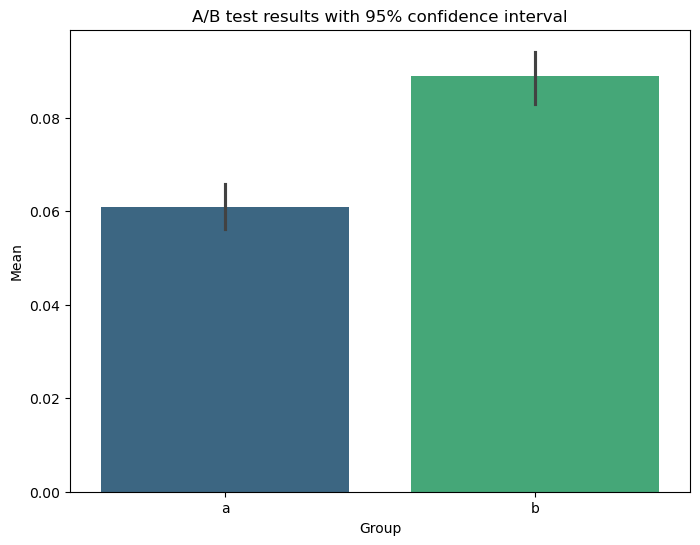

In [18]:
plt.figure(figsize=(8, 6))
sns.barplot(x=df_testing ['test_group'],
            y=df_testing ['conversion'],
            hue='test_group',
            data=df_testing,
            errorbar=('ci',95),
            palette='viridis')
plt.title ('A/B test results with 95% confidence interval')
plt.xlabel('Group')
plt.ylabel('Mean')
plt.show()

This visualization shows that the confidence intervals of the two groups do not overlap. This indicates that the difference in conversions is statistically significant with 95% confidence.

Therefore, we can reject the null hypothesis that there is no difference in conversion between Group A and Group B. As a result, we can roll out the new subscription offer of $4.99 with a 50% discount for users who have not yet seen the previous non-discounted message.

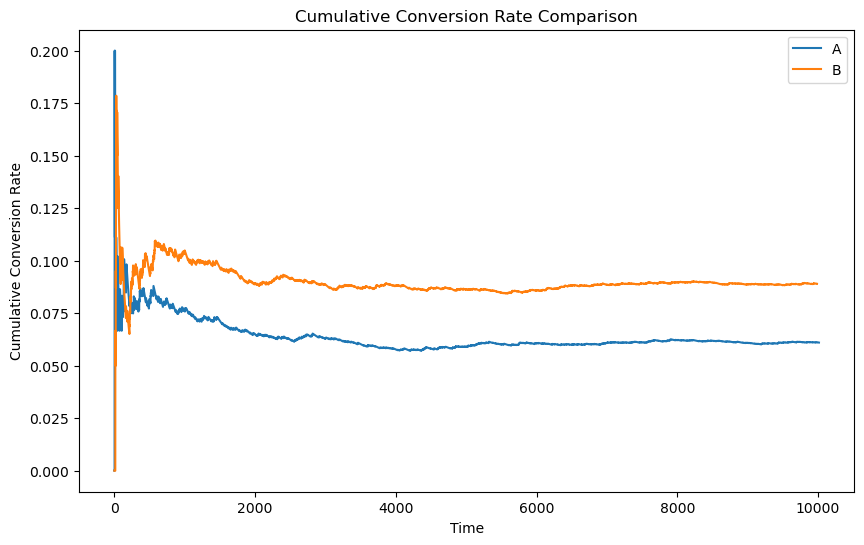

In [11]:
# We sort data in both groups by date and time to correctly calculate cumulative metrics
test_data_a = df_testing[df_testing['test_group'] == 'a'].sort_values('timestamp')
test_data_b = df_testing[df_testing['test_group'] == 'b'].sort_values('timestamp')
# We calculate cumulative mean - the change in conversion over time
cumulative_metric_a = df_testing[df_testing['test_group'] == 'a']['conversion'].expanding().mean().reset_index(drop=True)
cumulative_metric_b = df_testing[df_testing['test_group'] == 'b']['conversion'].expanding().mean().reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_metric_a, label='A')
plt.plot(cumulative_metric_b, label='B')

plt.title('Cumulative Сonversion Rate Comparison')
plt.xlabel('Time')
plt.ylabel('Cumulative Сonversion Rate')

plt.legend()
plt.show()

This chart demonstrates that the test reached statistical significance when each group accumulated around 1,000 users (the graph visually begins to stabilize).
On one hand, this suggests that a sample size of 1,000-2,000 users per group would have been sufficient for the test. On the other hand, increasing the sample size allows for more statistically significant and robust results.
The graph allows us to conclude that there is a definite difference between the groups, and we are more than 95% confident in this conclusion. Therefore, the test is a success.